<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/main/XGboost_multivariate_data_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [68]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [69]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [70]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

In [71]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [72]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [73]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [74]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
date_time                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2075259 rows x 7 columns]

# Data Imputation

In [75]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [76]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Fill NaN values using the mean for each column
#df_imputed = df.copy()
#df_imputed.fillna(df.mean(), inplace=True)

In [77]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [78]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  Sub_metering_4  
date_time                                            
2006-12-16 17:24:00            17.0       52.266667  
2006-12-16 17:25:00            16.0       72.333333  
2006-12-16 17:26:00            17.0       70.566667  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000  
...                             ...             ...  
2010-11-26 20:58:00             0.0       15.766667  
2010-11-26 20:59:00             0.0       15.733333  
2010-11-26 21:00:00             0.0       15.633333  
2010-11-26 21:01:00             0.0       15.566667  
2010-11-26 21:02:00             0.0       15.533333  

[2075259 rows x 8 columns]

# Hourly resampled data

## Multivariate-1 for for hourly resampled data

In [79]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

### EDA

In [80]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_resampled.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 


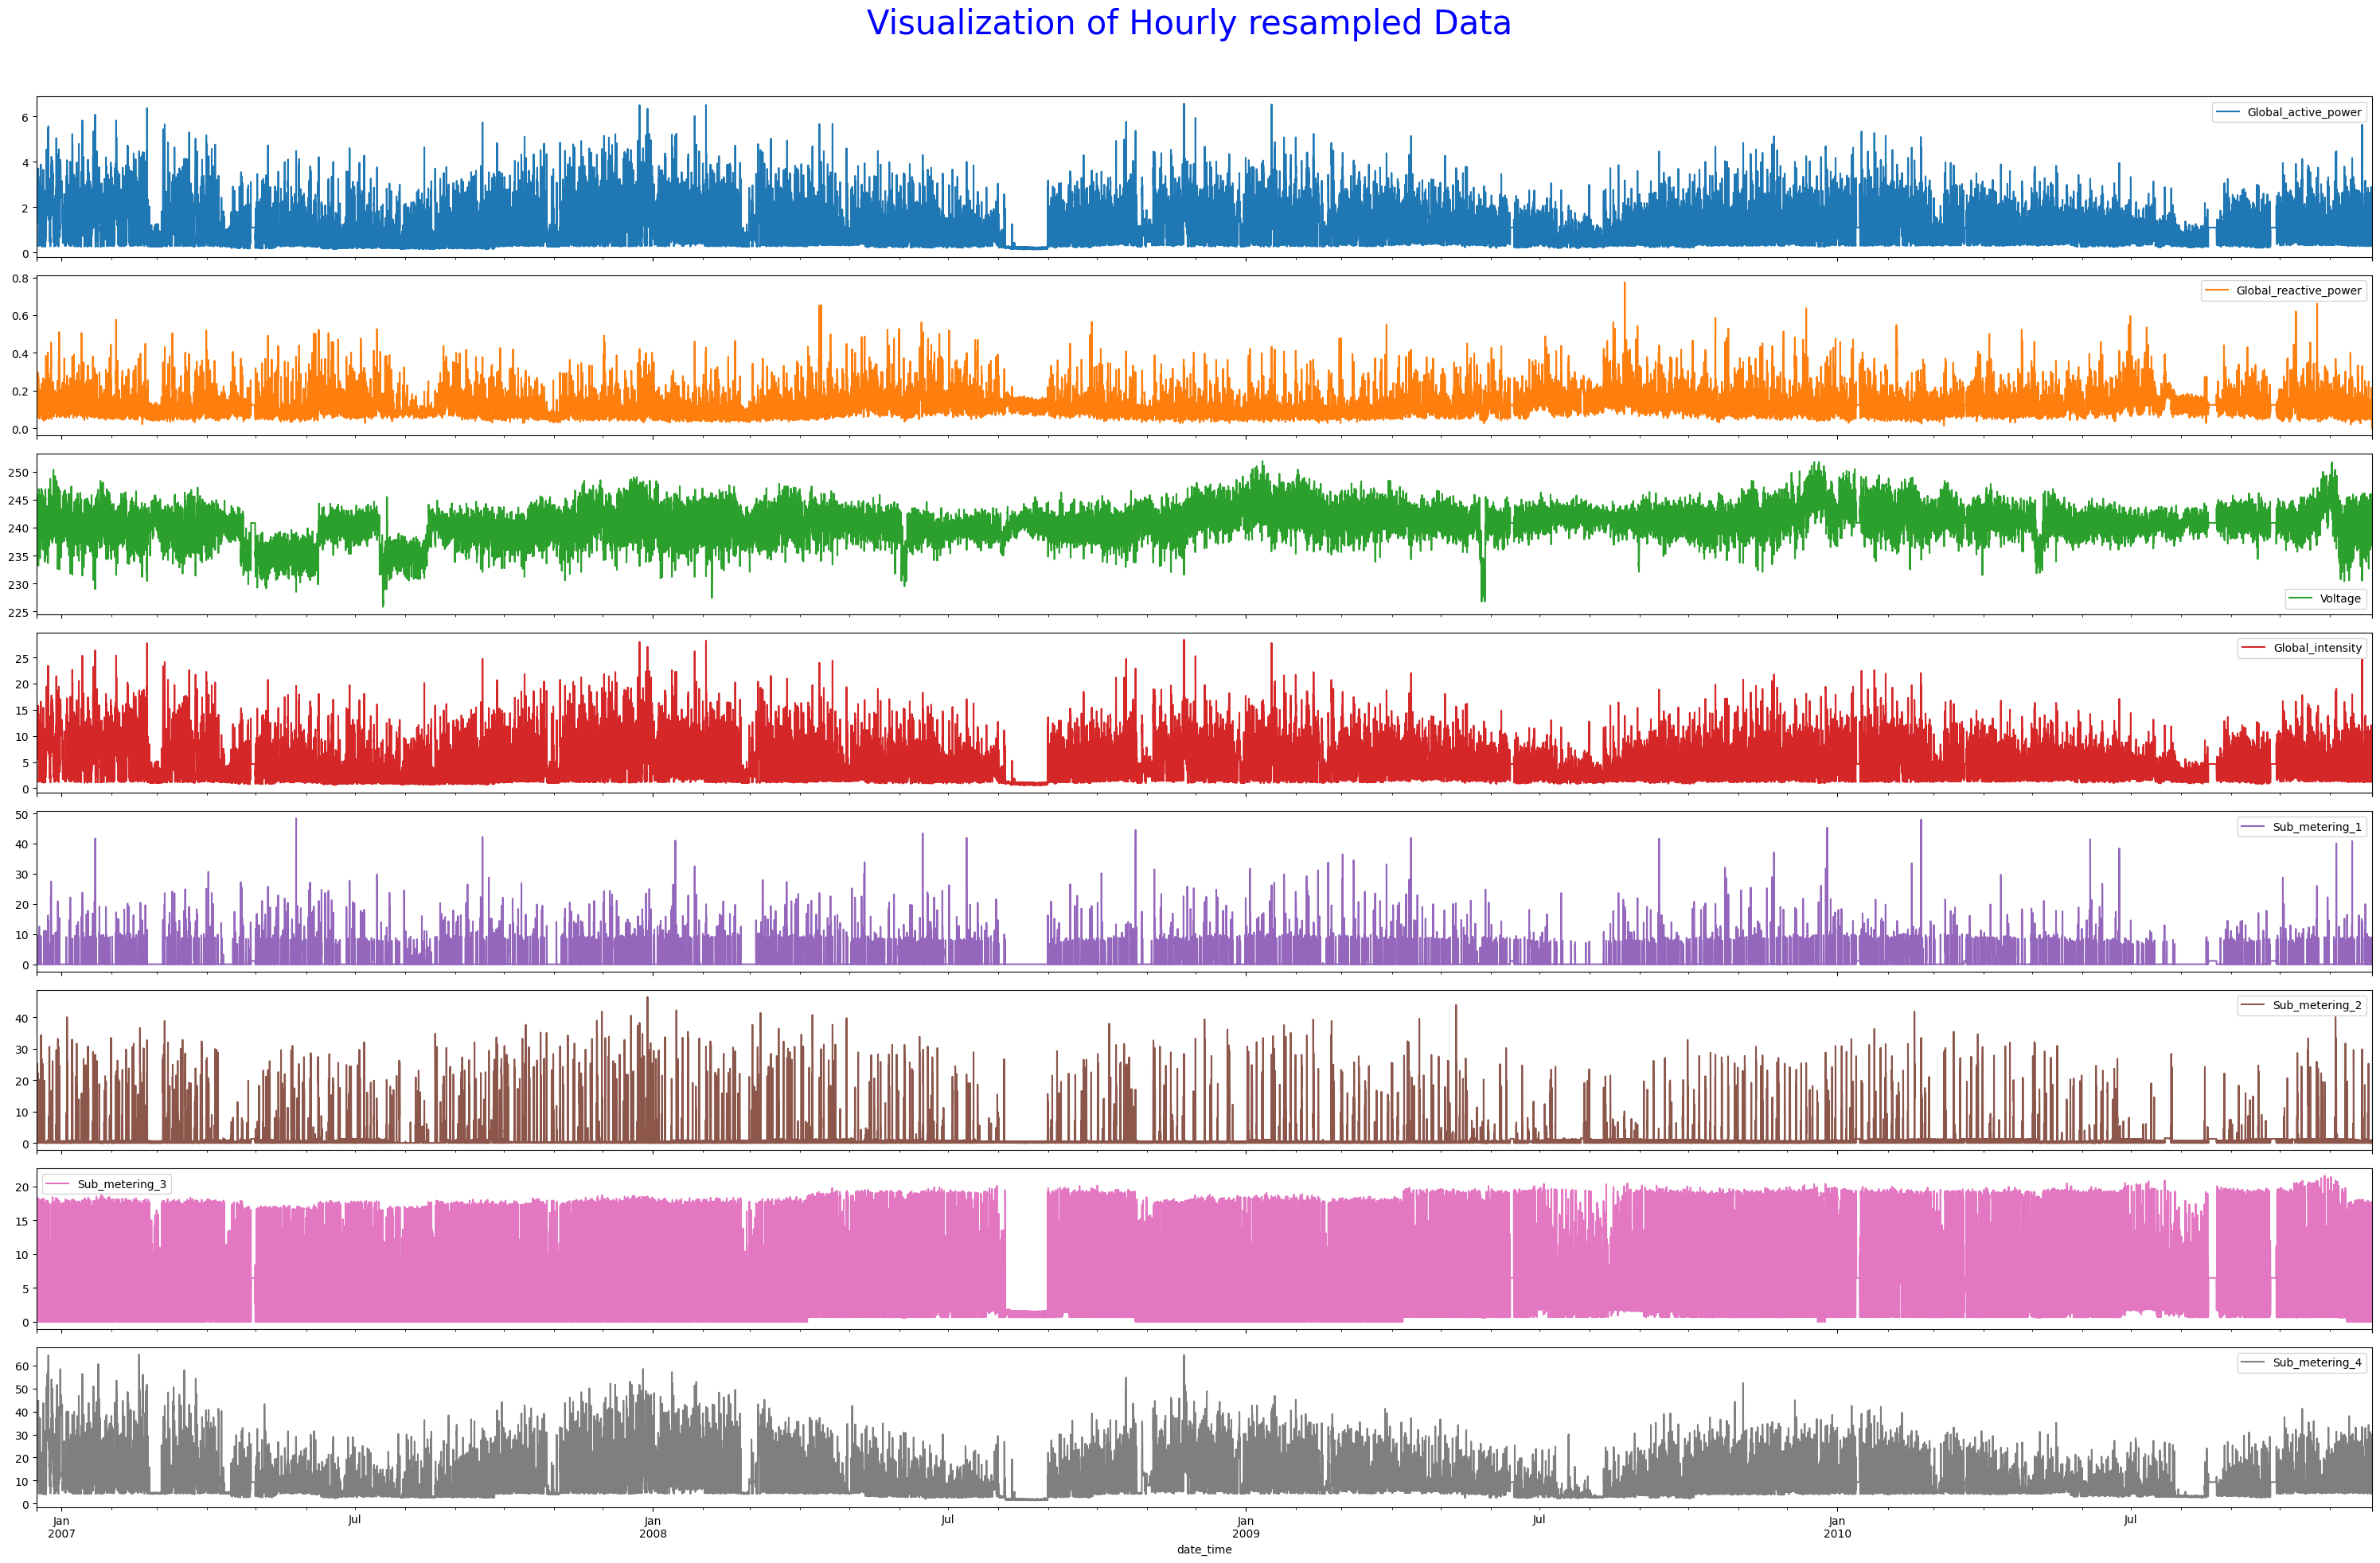

 

************************************************ Hourly Resampled distribution Plot **************************************************



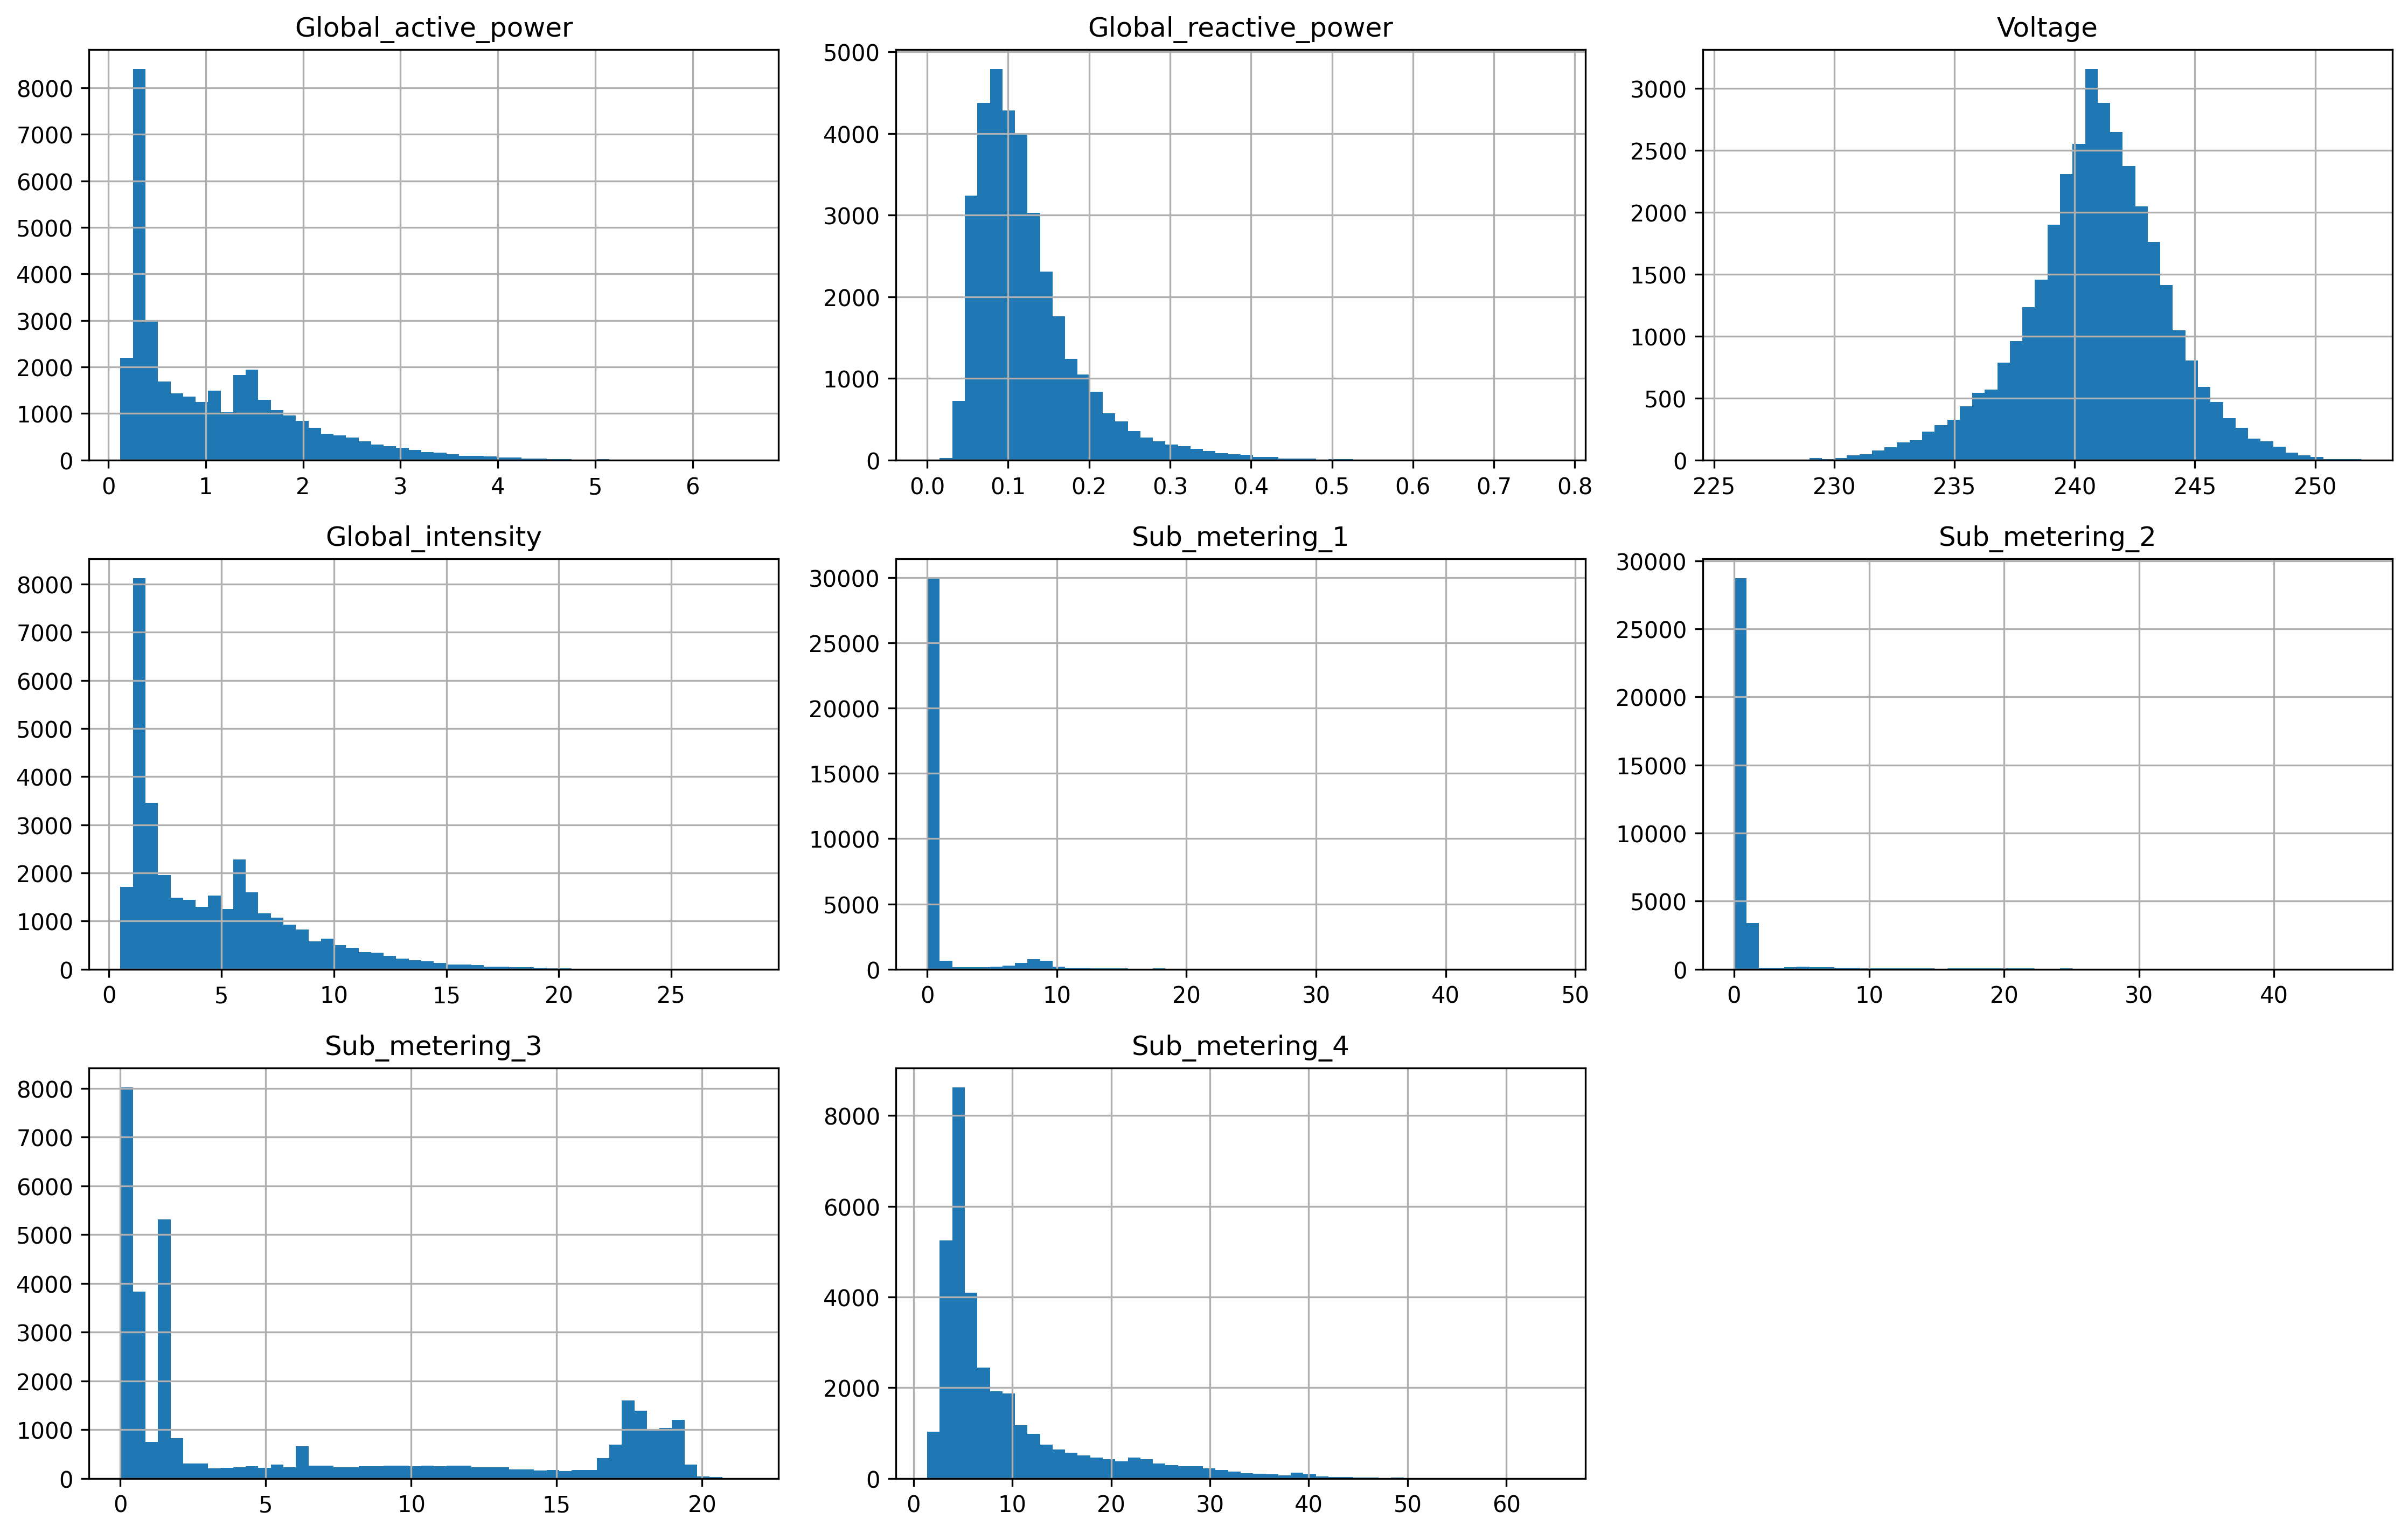

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



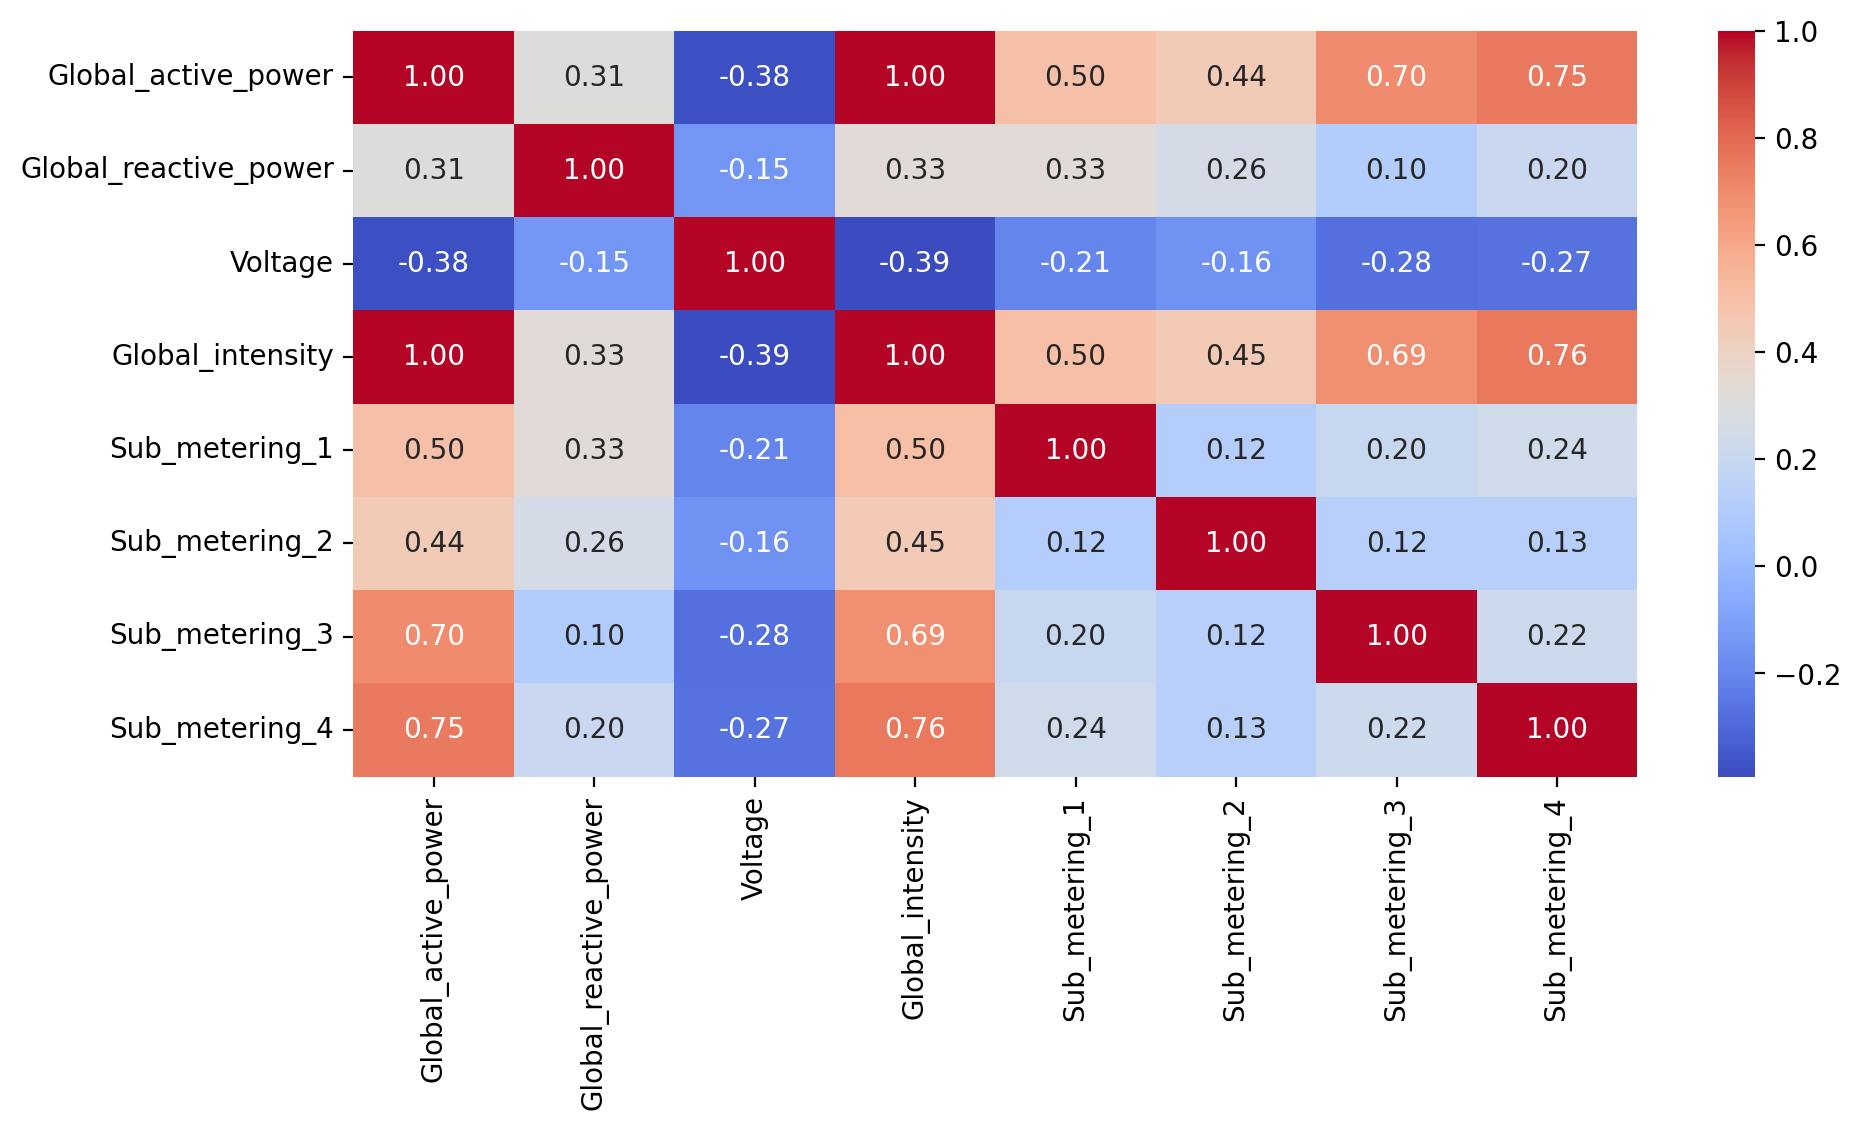

In [81]:
# Plot the visualization, distribution and correlation of Daily resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

In [82]:
# Remove the highly correlated columns
df1 = hourly_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)

### Data Normalization

In [83]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df1 = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns, index=df1.index)

# Shape of scaled data
scaled_df1.shape

(34589, 6)

### Train-Test Splitting

In [84]:
# Split the data into Train & Test Split
target = ['Global_active_power']
features = scaled_df1.drop(columns=['Global_active_power']).columns

train_size = int(len(scaled_df1) * 0.80)
df1_train = scaled_df1[:train_size]
df1_test = scaled_df1[train_size:]

X_train = df1_train[features]
y_train = df1_train[target]
X_test = df1_test[features]
y_test = df1_test[target]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27671, 5), (27671, 1), (6918, 5), (6918, 1))

### Xgboost model with default parameters

[0]	validation_0-rmse:0.11418	validation_1-rmse:0.08572
[99]	validation_0-rmse:0.05792	validation_1-rmse:0.05226


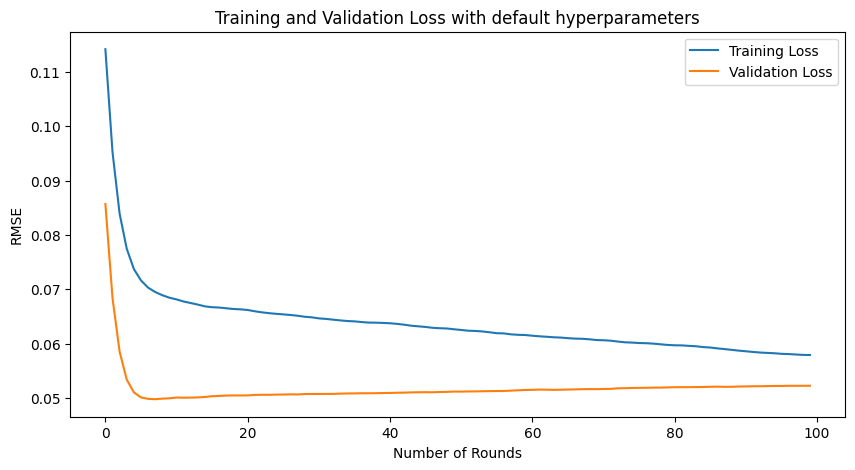


Train MAE: 0.254
Train MAPE: 0.342
Train MSE: 0.139
Train RMSE: 0.373

Test MAE: 0.233
Test MAPE: 0.268
Test MSE: 0.113
Test RMSE: 0.336


In [85]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss with default parameters
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with default hyperparameters')
plt.legend()
plt.show()

# Predictions with the model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df1.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df1.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

## Multivariate-2 for hourly resampled data

In [86]:
# Make new dataframe with Global active power column
df2 = hourly_resampled.drop(['Global_reactive_power','Voltage','Global_intensity',
                             'Sub_metering_1','Sub_metering_2','Sub_metering_3','Sub_metering_4'], axis=1)

### Feature Engineering

In [87]:
# Create new columns for hour, day, quarter, month, and year
df2['hour'] = df2.index.hour
df2['month'] = df2.index.month
df2['quarter'] = df2.index.quarter
df2['year'] = df2.index.year
df2['week_of_year'] = df2.index.isocalendar().week
df2['day_of_week'] = df2.index.dayofweek
df2['day_of_month'] = df2.index.day
df2['day_of_year'] = df2.index.dayofyear
df2

Global_active_power  hour  month  quarter  year  \
date_time                                                              
2006-12-16 17:00:00             4.222889    17     12        4  2006   
2006-12-16 18:00:00             3.632200    18     12        4  2006   
2006-12-16 19:00:00             3.400233    19     12        4  2006   
2006-12-16 20:00:00             3.268567    20     12        4  2006   
2006-12-16 21:00:00             3.056467    21     12        4  2006   
...                                  ...   ...    ...      ...   ...   
2010-11-26 17:00:00             1.725900    17     11        4  2010   
2010-11-26 18:00:00             1.573467    18     11        4  2010   
2010-11-26 19:00:00             1.659333    19     11        4  2010   
2010-11-26 20:00:00             1.163700    20     11        4  2010   
2010-11-26 21:00:00             0.934667    21     11        4  2010   

                     week_of_year  day_of_week  day_of_month  day_of_year  
date_time                                                                  
2006-12-16 17:00:00            50            5            16          350  
2006-12-16 18:00:00            50            5            16          350  
2006-12-16 19:00:00            50            5            16          350  
2006-12-16 20:00:00            50            5            16          350  
2006-12-16 21:00:00            50            5            16          350  
...                           ...          ...           ...          ...  
2010-11-26 17:00:00            47            4            26          330  
2010-11-26 18:00:00            47            4            26          330  
2010-11-26 19:00:00            47            4            26          330  
2010-11-26 20:00:00            47            4            26          330  
2010-11-26 21:00:00            47            4            26          330  

[34589 rows x 9 columns]

### Data Normalization

In [88]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns, index=df2.index)

# Shape of scaled data
scaled_df2.shape

(34589, 9)

### Train-Test Splitting

In [89]:
# Split the data into Train & Test Split
target = ['Global_active_power']
features = scaled_df2.drop(columns=['Global_active_power']).columns

train_size = int(len(scaled_df2) * 0.80)
df2_train = scaled_df2[:train_size]
df2_test = scaled_df2[train_size:]

X_train = df2_train[features]
y_train = df2_train[target]
X_test = df2_test[features]
y_test = df2_test[target]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27671, 8), (27671, 1), (6918, 8), (6918, 1))

### Xgboost model with default parameters

[0]	validation_0-rmse:0.12967	validation_1-rmse:0.10321
[99]	validation_0-rmse:0.08068	validation_1-rmse:0.10045


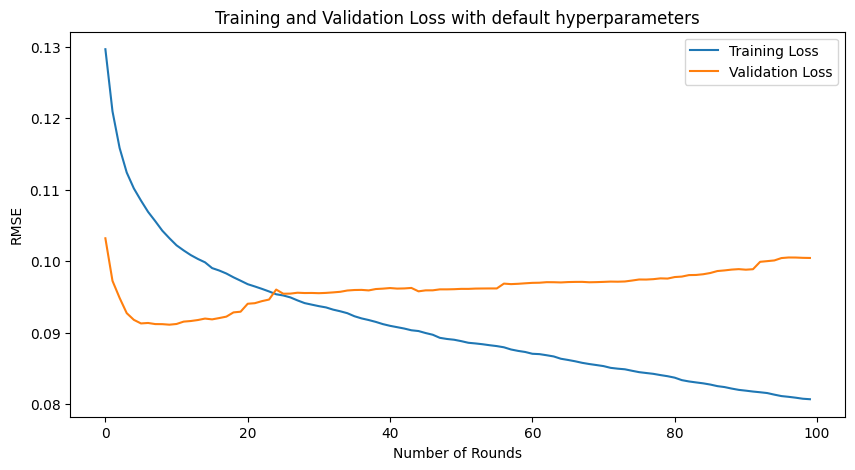


Train MAE: 0.371
Train MAPE: 0.535
Train MSE: 0.270
Train RMSE: 0.519

Test MAE: 0.474
Test MAPE: 0.653
Test MSE: 0.418
Test RMSE: 0.647


In [90]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss with default parameters
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with default hyperparameters')
plt.legend()
plt.show()

# Predictions with the model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df2.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df2.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df2.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df2.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

## Multivariate-3 for hourly resampled data

In [91]:
# Remove the highly correlated columns
df3 = hourly_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)

### Feature Engineering

In [92]:
# Create new columns for hour, day, quarter, month, and year
df3['hour'] = df3.index.hour
df3['month'] = df3.index.month
df3['quarter'] = df3.index.quarter
df3['year'] = df3.index.year
df3['week_of_year'] = df3.index.isocalendar().week
df3['day_of_week'] = df3.index.dayofweek
df3['day_of_month'] = df3.index.day
df3['day_of_year'] = df3.index.dayofyear
df3

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                                     
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   
...                                  ...                    ...         ...   
2010-11-26 17:00:00             1.725900               0.061400  237.069667   
2010-11-26 18:00:00             1.573467               0.053700  237.531833   
2010-11-26 19:00:00             1.659333               0.060033  236.741000   
2010-11-26 20:00:00             1.163700               0.061167  239.396000   
2010-11-26 21:00:00             0.934667               0.000000  239.690000   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  hour  \
date_time                                                                   
2006-12-16 17:00:00             0.0        0.527778       16.861111    17   
2006-12-16 18:00:00             0.0        6.716667       16.866667    18   
2006-12-16 19:00:00             0.0        1.433333       16.683333    19   
2006-12-16 20:00:00             0.0        0.000000       16.783333    20   
2006-12-16 21:00:00             0.0        0.416667       17.216667    21   
...                             ...             ...             ...   ...   
2010-11-26 17:00:00             0.0        0.000000       12.866667    17   
2010-11-26 18:00:00             0.0        0.000000        0.000000    18   
2010-11-26 19:00:00             0.0        0.066667        0.000000    19   
2010-11-26 20:00:00             0.0        1.066667        0.000000    20   
2010-11-26 21:00:00             0.0        0.000000        0.000000    21   

                     month  quarter  year  week_of_year  day_of_week  \
date_time                                                              
2006-12-16 17:00:00     12        4  2006            50            5   
2006-12-16 18:00:00     12        4  2006            50            5   
2006-12-16 19:00:00     12        4  2006            50            5   
2006-12-16 20:00:00     12        4  2006            50            5   
2006-12-16 21:00:00     12        4  2006            50            5   
...                    ...      ...   ...           ...          ...   
2010-11-26 17:00:00     11        4  2010            47            4   
2010-11-26 18:00:00     11        4  2010            47            4   
2010-11-26 19:00:00     11        4  2010            47            4   
2010-11-26 20:00:00     11        4  2010            47            4   
2010-11-26 21:00:00     11        4  2010            47            4   

                     day_of_month  day_of_year  
date_time                                       
2006-12-16 17:00:00            16          350  
2006-12-16 18:00:00            16          350  
2006-12-16 19:00:00            16          350  
2006-12-16 20:00:00            16          350  
2006-12-16 21:00:00            16          350  
...                           ...          ...  
2010-11-26 17:00:00            26          330  
2010-11-26 18:00:00            26          330  
2010-11-26 19:00:00            26          330  
2010-11-26 20:00:00            26          330  
2010-11-26 21:00:00            26          330  

[34589 rows x 14 columns]

### Data Normalization

In [93]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df3 = pd.DataFrame(scaler.fit_transform(df3), columns=df3.columns, index=df3.index)

# Shape of scaled data
scaled_df3.shape

(34589, 14)

### Train-Test Splitting

In [94]:
# Split the data into Train & Test Split
target = ['Global_active_power']
features = scaled_df3.drop(columns=['Global_active_power']).columns

train_size = int(len(scaled_df3) * 0.80)
df3_train = scaled_df3[:train_size]
df3_test = scaled_df3[train_size:]

X_train = df3_train[features]
y_train = df3_train[target]
X_test = df3_test[features]
y_test = df3_test[target]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27671, 13), (27671, 1), (6918, 13), (6918, 1))

### Xgboost model with default parameters

[0]	validation_0-rmse:0.11225	validation_1-rmse:0.08449
[99]	validation_0-rmse:0.03181	validation_1-rmse:0.04214


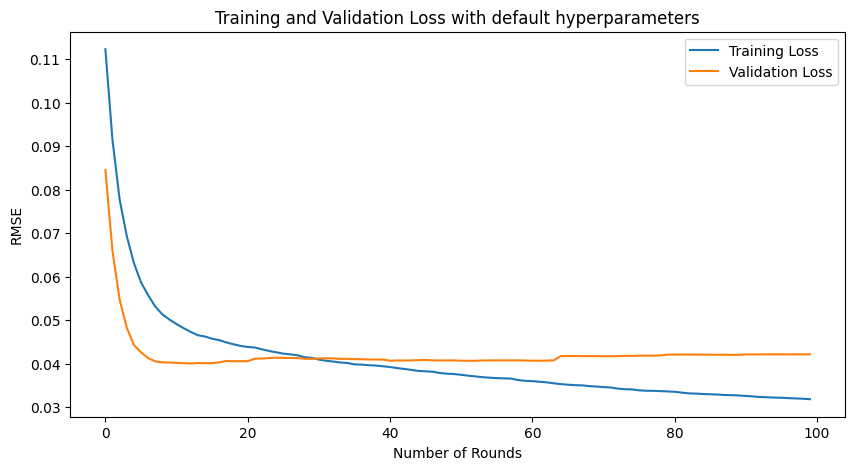


Train MAE: 0.137
Train MAPE: 0.176
Train MSE: 0.042
Train RMSE: 0.205

Test MAE: 0.186
Test MAPE: 0.235
Test MSE: 0.074
Test RMSE: 0.271


In [95]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss with default parameters
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with default hyperparameters')
plt.legend()
plt.show()

# Predictions with the model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df3.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df3.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df3.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df3.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

# Daily resampled data

## Multivariate-1 for for daily resampled data

In [96]:
# Resampled the data
daily_resampled = df_imputed.resample('D').mean()

### EDA

In [97]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_resampled.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Daily resampling of data : (1442, 8) 


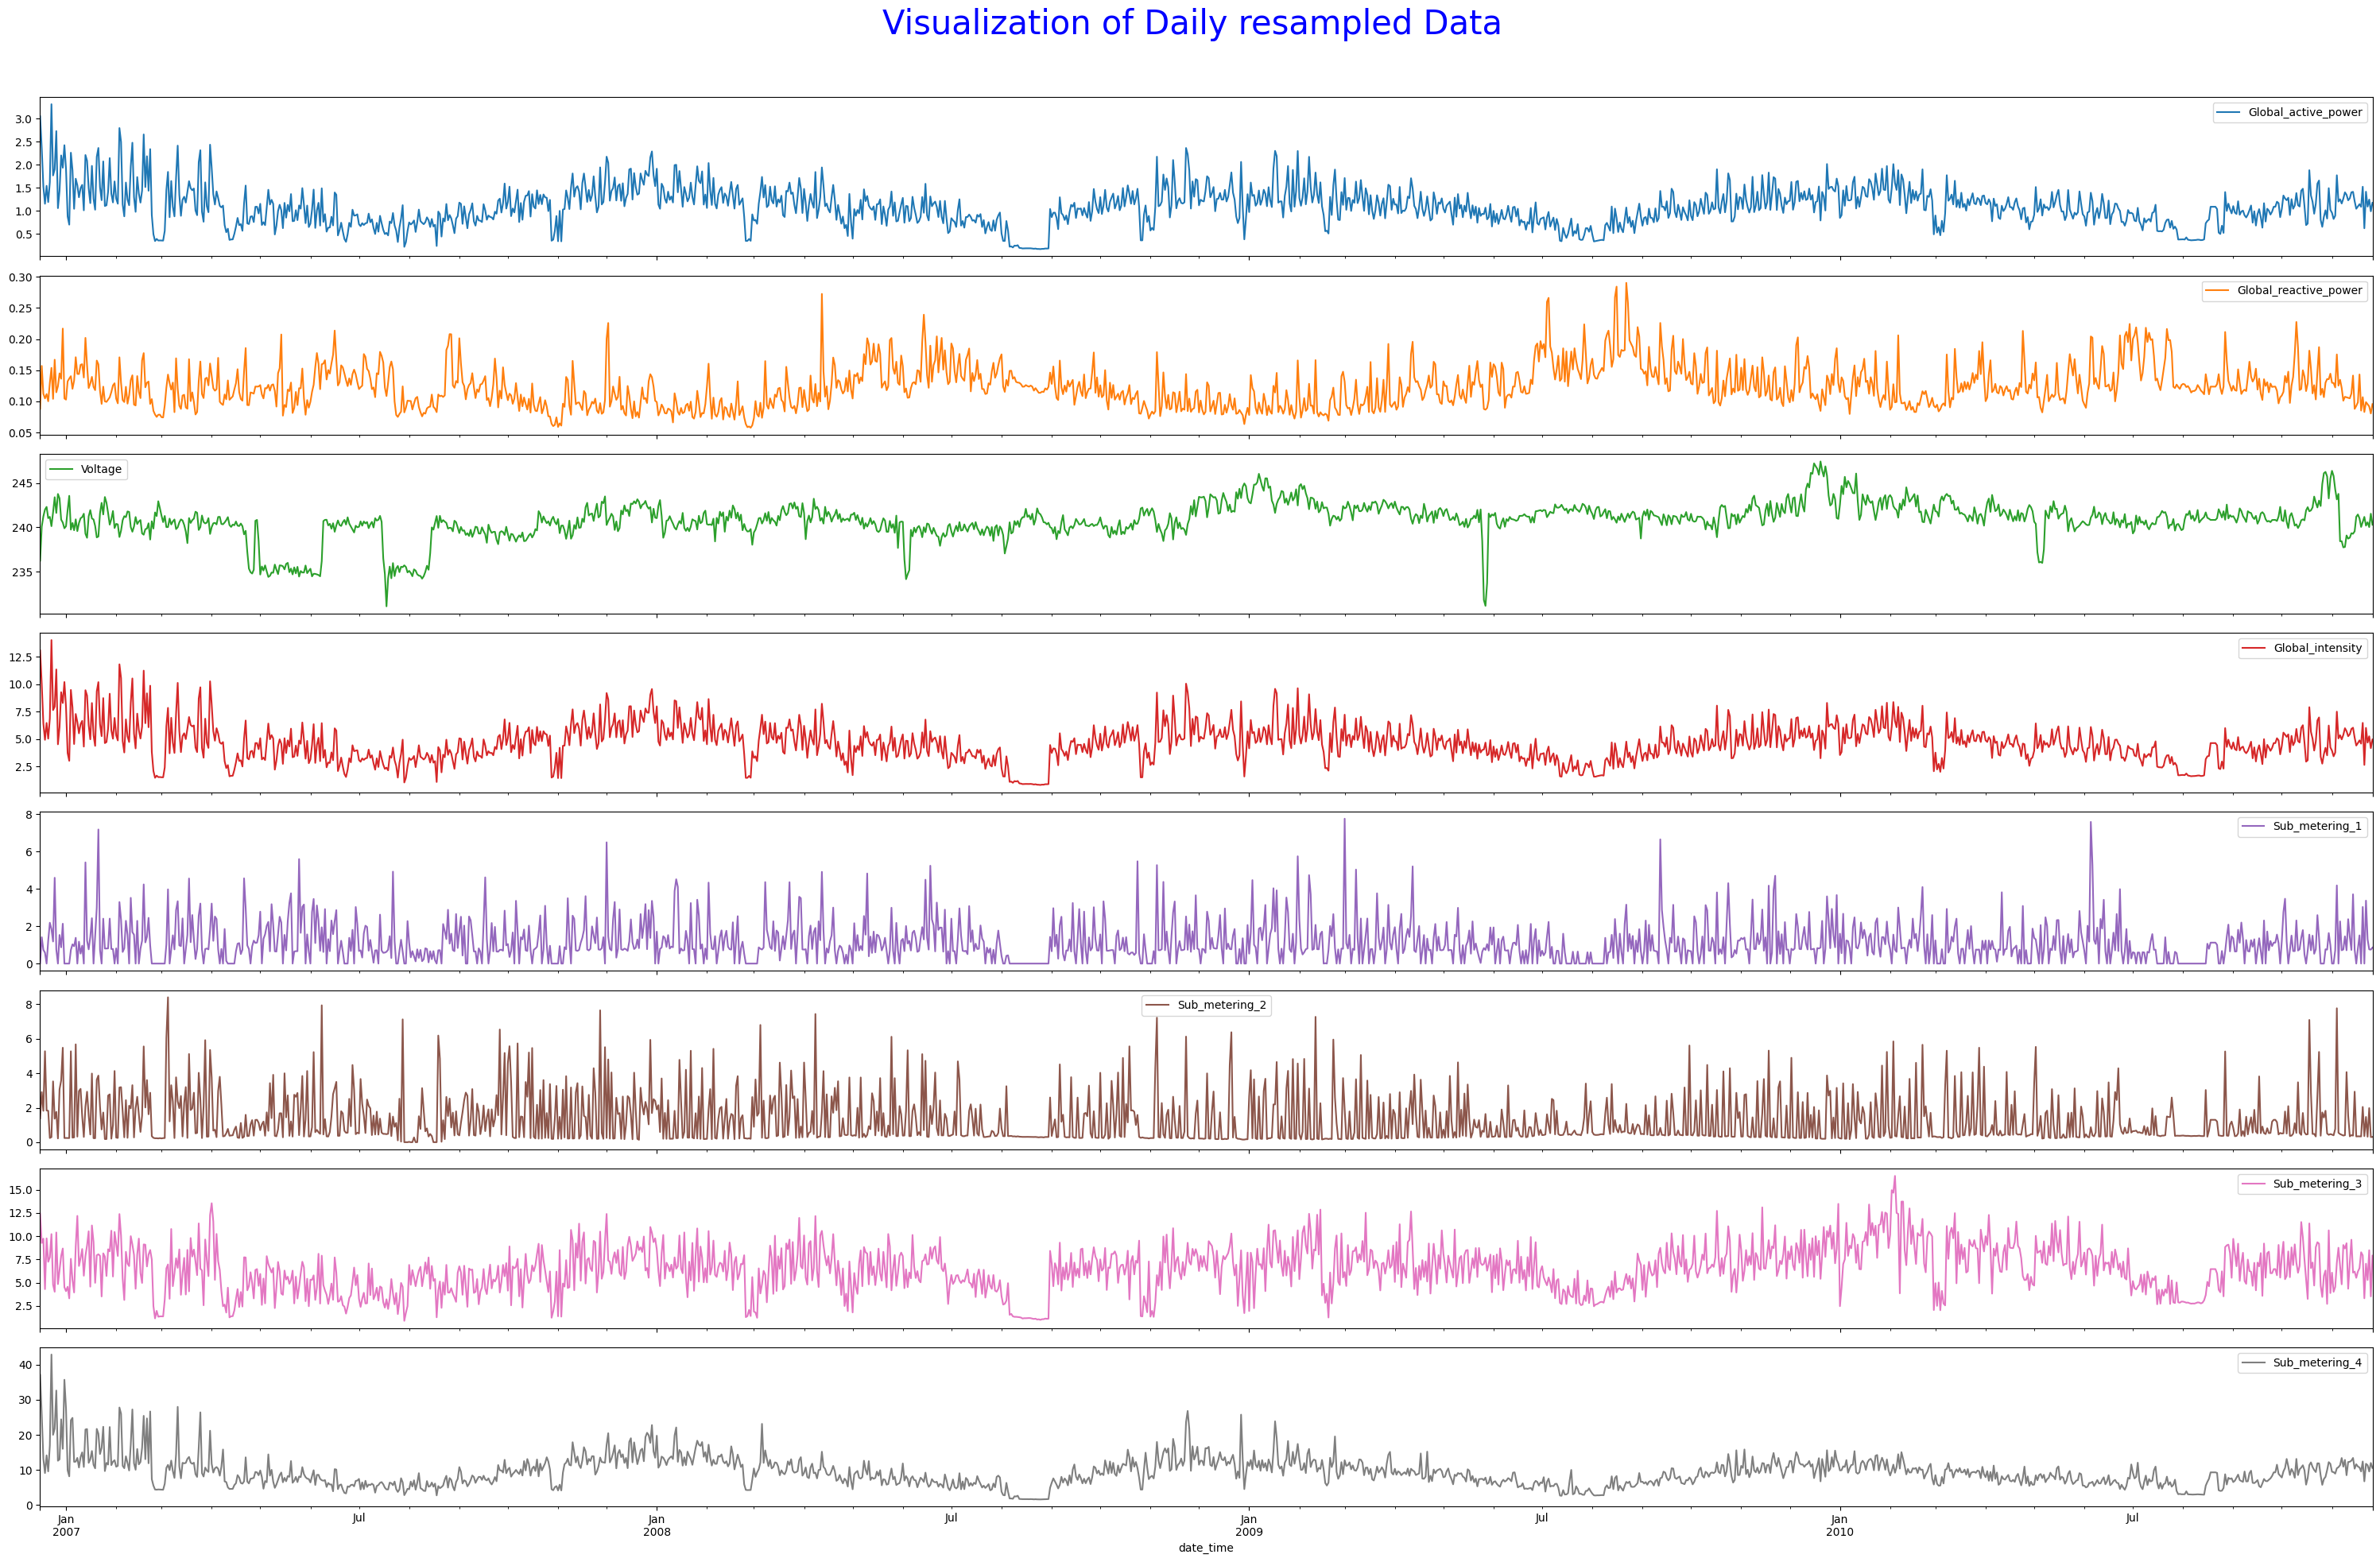

 

************************************************ Daily Resampled distribution Plot **************************************************



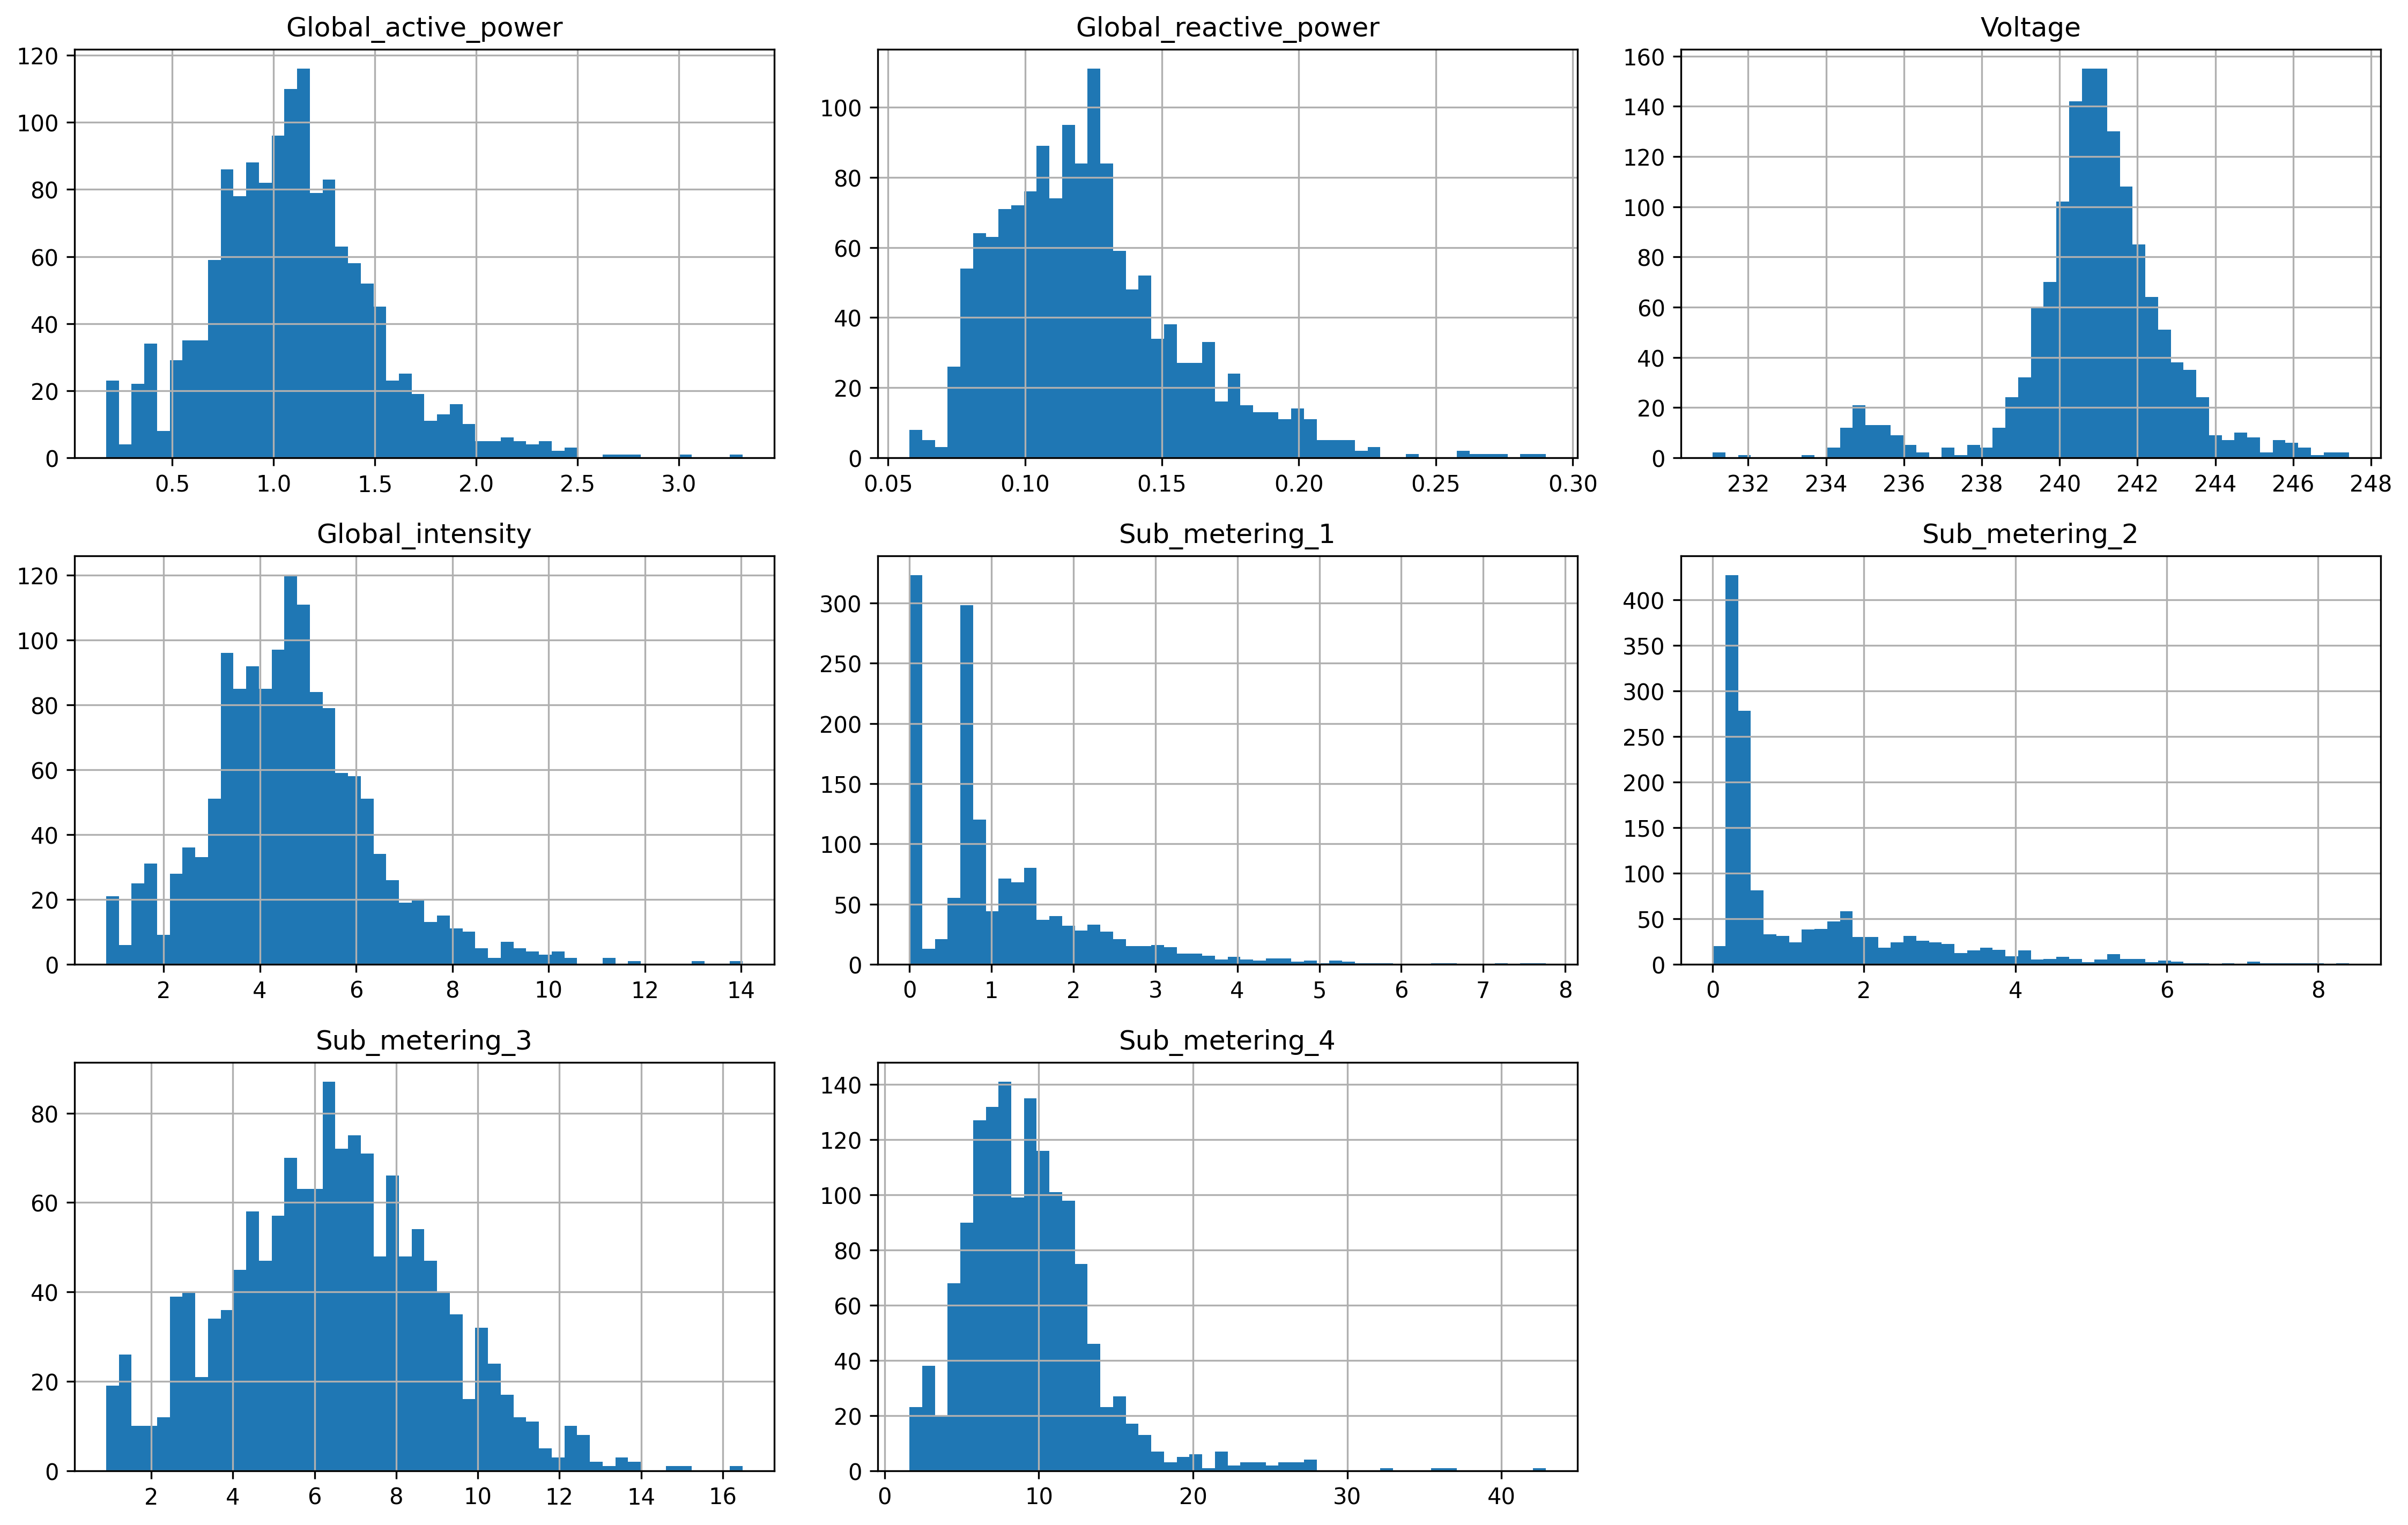

 

************************************************ Correlation Plot for Daily Resampled Data **************************************************



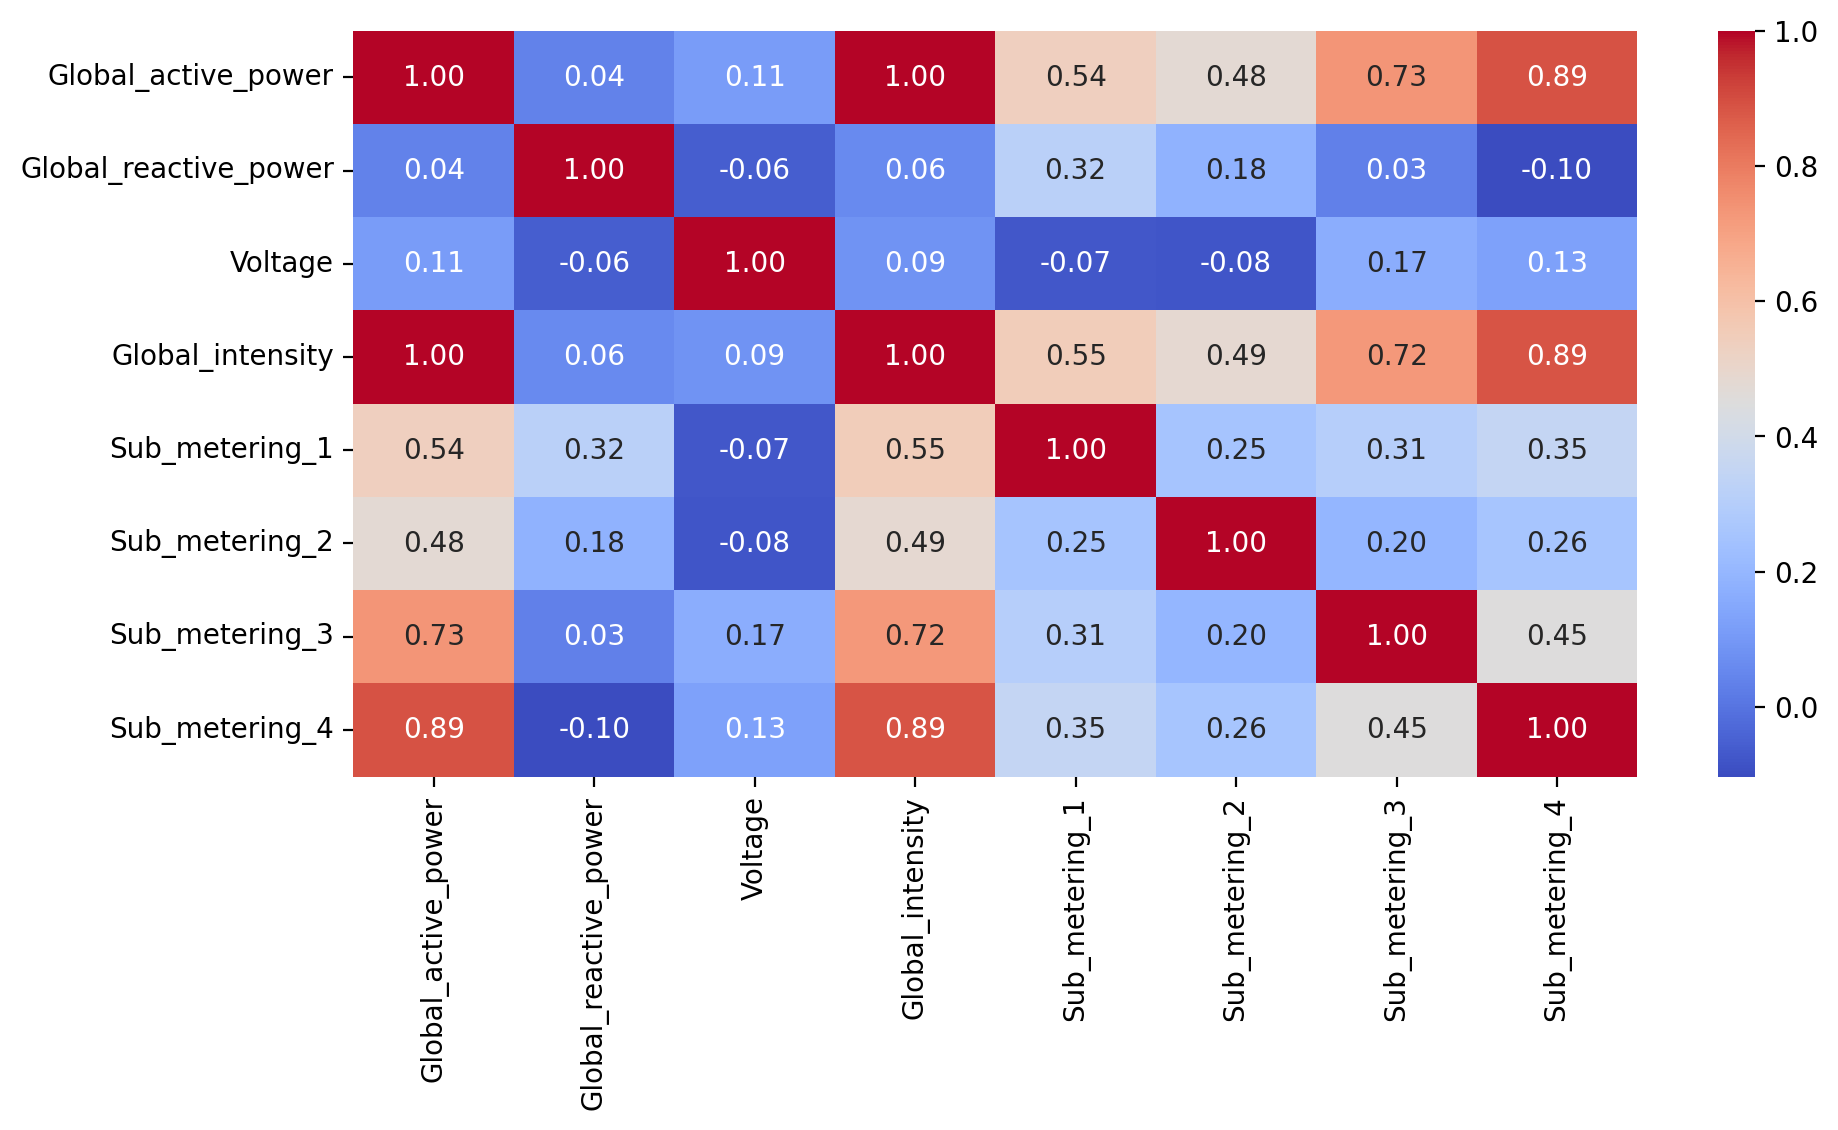

In [98]:
# Plot the visualization, distribution and correlation of Daily resampled data
df_visu_dist_corr(df_imputed, "D", "Daily")

In [99]:
# Remove the highly correlated columns
df4 = daily_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)

### Data Normalization

In [100]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df4 = pd.DataFrame(scaler.fit_transform(df4), columns=df4.columns, index=df4.index)

# Shape of scaled data
scaled_df4.shape

(1442, 6)

### Train-Test Splitting

In [101]:
# Split the data into Train & Test Split
target = ['Global_active_power']
features = scaled_df4.drop(columns=['Global_active_power']).columns

train_size = int(len(scaled_df4) * 0.80)
df4_train = scaled_df4[:train_size]
df4_test = scaled_df4[train_size:]

X_train = df4_train[features]
y_train = df4_train[target]
X_test = df4_test[features]
y_test = df4_test[target]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1153, 5), (1153, 1), (289, 5), (289, 1))

### Xgboost model with default parameters

[0]	validation_0-rmse:0.10852	validation_1-rmse:0.07671
[99]	validation_0-rmse:0.00748	validation_1-rmse:0.05781


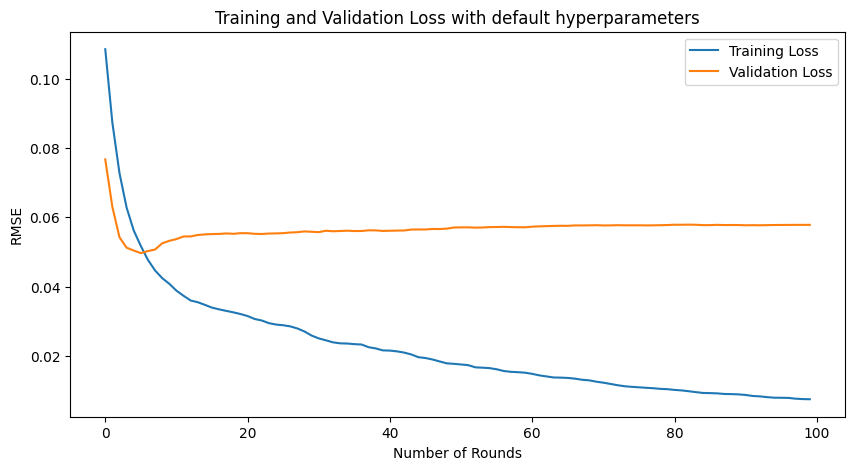


Train MAE: 0.016
Train MAPE: 0.017
Train MSE: 0.001
Train RMSE: 0.023

Test MAE: 0.138
Test MAPE: 0.144
Test MSE: 0.033
Test RMSE: 0.182


In [102]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss with default parameters
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with default hyperparameters')
plt.legend()
plt.show()

# Predictions with the model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df4.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df4.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df4.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df4.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

## Multivariate-2 for hourly resampled data

In [103]:
# Make new dataframe with Global active power column
df5 = daily_resampled.drop(['Global_reactive_power','Voltage','Global_intensity',
                             'Sub_metering_1','Sub_metering_2','Sub_metering_3','Sub_metering_4'], axis=1)

### Feature Engineering

In [104]:
# Create new columns for hour, day, quarter, month, and year
df5['hour'] = df5.index.hour
df5['month'] = df5.index.month
df5['quarter'] = df5.index.quarter
df5['year'] = df5.index.year
df5['week_of_year'] = df5.index.isocalendar().week
df5['day_of_week'] = df5.index.dayofweek
df5['day_of_month'] = df5.index.day
df5['day_of_year'] = df5.index.dayofyear
df5

Global_active_power  hour  month  quarter  year  week_of_year  \
date_time                                                                   
2006-12-16             3.053475     0     12        4  2006            50   
2006-12-17             2.354486     0     12        4  2006            50   
2006-12-18             1.530435     0     12        4  2006            51   
2006-12-19             1.157079     0     12        4  2006            51   
2006-12-20             1.545658     0     12        4  2006            51   
...                         ...   ...    ...      ...   ...           ...   
2010-11-22             1.417733     0     11        4  2010            47   
2010-11-23             1.095511     0     11        4  2010            47   
2010-11-24             1.247394     0     11        4  2010            47   
2010-11-25             0.993864     0     11        4  2010            47   
2010-11-26             1.178230     0     11        4  2010            47   

            day_of_week  day_of_month  day_of_year  
date_time                                           
2006-12-16            5            16          350  
2006-12-17            6            17          351  
2006-12-18            0            18          352  
2006-12-19            1            19          353  
2006-12-20            2            20          354  
...                 ...           ...          ...  
2010-11-22            0            22          326  
2010-11-23            1            23          327  
2010-11-24            2            24          328  
2010-11-25            3            25          329  
2010-11-26            4            26          330  

[1442 rows x 9 columns]

### Data Normalization

In [105]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df5 = pd.DataFrame(scaler.fit_transform(df5), columns=df5.columns, index=df5.index)

# Shape of scaled data
scaled_df5.shape

(1442, 9)

### Train-Test Splitting

In [106]:
# Split the data into Train & Test Split
target = ['Global_active_power']
features = scaled_df5.drop(columns=['Global_active_power']).columns

train_size = int(len(scaled_df5) * 0.80)
df5_train = scaled_df5[:train_size]
df5_test = scaled_df5[train_size:]

X_train = df5_train[features]
y_train = df5_train[target]
X_test = df5_test[features]
y_test = df5_test[target]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1153, 8), (1153, 1), (289, 8), (289, 1))

### Xgboost model with default parameters

[0]	validation_0-rmse:0.11531	validation_1-rmse:0.08705
[99]	validation_0-rmse:0.02265	validation_1-rmse:0.08839


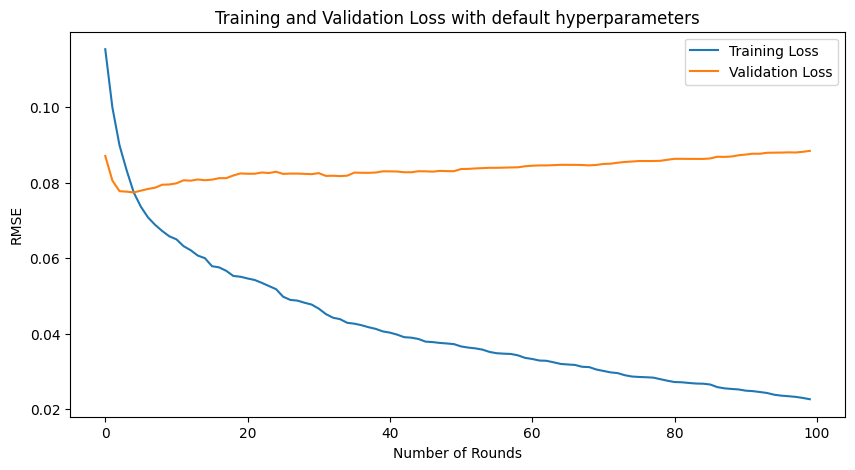


Train MAE: 0.053
Train MAPE: 0.061
Train MSE: 0.005
Train RMSE: 0.071

Test MAE: 0.213
Test MAPE: 0.231
Test MSE: 0.077
Test RMSE: 0.278


In [107]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss with default parameters
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with default hyperparameters')
plt.legend()
plt.show()

# Predictions with the model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df5.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df5.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df5.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df5.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')

## Multivariate-3 for hourly resampled data

In [108]:
# Remove the highly correlated columns
df6 = daily_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)

### Feature Engineering

In [109]:
# Create new columns for hour, day, quarter, month, and year
df6['hour'] = df6.index.hour
df6['month'] = df6.index.month
df6['quarter'] = df6.index.quarter
df6['year'] = df6.index.year
df6['week_of_year'] = df6.index.isocalendar().week
df6['day_of_week'] = df6.index.dayofweek
df6['day_of_month'] = df6.index.day
df6['day_of_year'] = df6.index.dayofyear
df6

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                            
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   
...                         ...                    ...         ...   
2010-11-22             1.417733               0.098857  240.197118   
2010-11-23             1.095511               0.095451  240.575528   
2010-11-24             1.247394               0.091986  240.030965   
2010-11-25             0.993864               0.080644  241.536257   
2010-11-26             1.178230               0.095666  240.291029   

            Sub_metering_1  Sub_metering_2  Sub_metering_3  hour  month  \
date_time                                                                 
2006-12-16        0.000000        1.378788       12.439394     0     12   
2006-12-17        1.411806        2.907639        9.264583     0     12   
2006-12-18        0.738194        1.820139        9.734722     0     12   
2006-12-19        0.582639        5.279167        4.303472     0     12   
2006-12-20        0.000000        1.838889        9.765972     0     12   
...                    ...             ...             ...   ...    ...   
2010-11-22        3.371528        1.465278        7.038889     0     11   
2010-11-23        1.299306        0.318056        5.285417     0     11   
2010-11-24        0.761111        1.977778        8.488889     0     11   
2010-11-25        0.747222        0.295833        3.522222     0     11   
2010-11-26        0.855107        0.304830        7.908947     0     11   

            quarter  year  week_of_year  day_of_week  day_of_month  \
date_time                                                            
2006-12-16        4  2006            50            5            16   
2006-12-17        4  2006            50            6            17   
2006-12-18        4  2006            51            0            18   
2006-12-19        4  2006            51            1            19   
2006-12-20        4  2006            51            2            20   
...             ...   ...           ...          ...           ...   
2010-11-22        4  2010            47            0            22   
2010-11-23        4  2010            47            1            23   
2010-11-24        4  2010            47            2            24   
2010-11-25        4  2010            47            3            25   
2010-11-26        4  2010            47            4            26   

            day_of_year  
date_time                
2006-12-16          350  
2006-12-17          351  
2006-12-18          352  
2006-12-19          353  
2006-12-20          354  
...                 ...  
2010-11-22          326  
2010-11-23          327  
2010-11-24          328  
2010-11-25          329  
2010-11-26          330  

[1442 rows x 14 columns]

### Data Normalization

In [110]:
# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_df6 = pd.DataFrame(scaler.fit_transform(df6), columns=df6.columns, index=df6.index)

# Shape of scaled data
scaled_df6.shape

(1442, 14)

### Train-Test Splitting

In [111]:
# Split the data into Train & Test Split
target = ['Global_active_power']
features = scaled_df6.drop(columns=['Global_active_power']).columns

train_size = int(len(scaled_df6) * 0.80)
df6_train = scaled_df6[:train_size]
df6_test = scaled_df6[train_size:]

X_train = df6_train[features]
y_train = df6_train[target]
X_test = df6_test[features]
y_test = df6_test[target]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1153, 13), (1153, 1), (289, 13), (289, 1))

### Xgboost model with default parameters

[0]	validation_0-rmse:0.10688	validation_1-rmse:0.07612
[99]	validation_0-rmse:0.00287	validation_1-rmse:0.04067


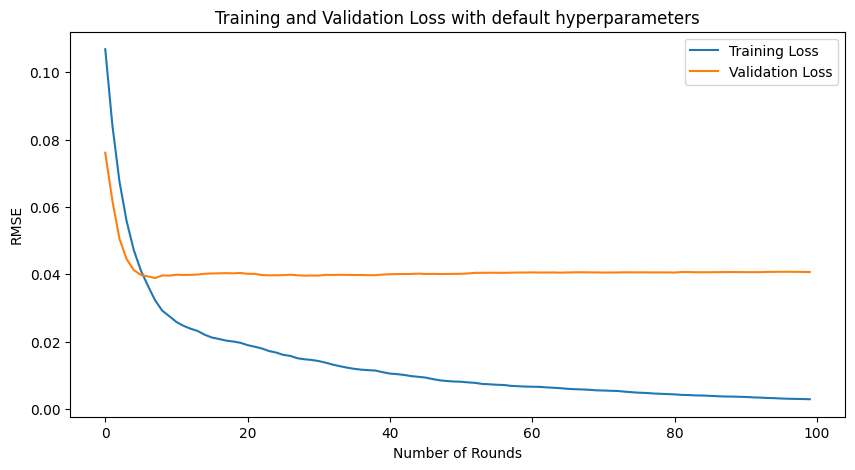


Train MAE: 0.006
Train MAPE: 0.007
Train MSE: 0.000
Train RMSE: 0.009

Test MAE: 0.099
Test MAPE: 0.102
Test MSE: 0.016
Test RMSE: 0.128


In [112]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss with default parameters
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with default hyperparameters')
plt.legend()
plt.show()

# Predictions with the model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train, df6.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict.reshape(-1,1), df6.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test, df6.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for train data
test_prediction_copies = np.repeat(test_predict.reshape(-1,1), df6.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_train_y, pred_train_y):.3f}')
print(f'Train MAPE: {mean_absolute_percentage_error(true_train_y, pred_train_y):.3f}')
print(f'Train MSE: {mean_squared_error(true_train_y, pred_train_y):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_train_y, pred_train_y)):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_test_y, pred_test_y):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(true_test_y, pred_test_y):.3f}')
print(f'Test MSE: {mean_squared_error(true_test_y, pred_test_y):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_test_y, pred_test_y)):.3f}')